# Playing with Apple Health Data

## PLANNING

1) Read the XML file into a dataframe
2) Whittle down the data into just Dexcom G6 data
3) Clean up the dataframe a little bit
4) Export the dataframe into a csv
5) Conduct feature engineering
6) Conduct Exploratory Data Analysis (make pretty graphs)
7) Predict whether blood sugar is high, or not
8) Do some time-series forecasting
9) Make a pretty presentation!

In [1]:
# setting the random seed for reproducibility
import random
random.seed(493)

# for reading the xml file
import xml.etree.ElementTree as ET

# for manipulating dataframes
import pandas as pd
import numpy as np

# for working with timestamps
import datetime as dt
from dateutil.parser import parse

# for modeling
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics

# for time-series forecasting
import matplotlib.pyplot as plt
from prophet import Prophet

# for visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# to print out all the outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
def get_values(df, columns):
    """
    Take a dataframe and a list of columns and
    returns the value counts for the columns.
    """
    for column in columns:
        print(column)
        print('=====================================')
        print(df[column].value_counts(dropna=False))
        print('\n')

def show_values(df, param):
    if param == 'all':
        get_values(df, df.columns)
    else:
        get_values(df, param) 

## ACQUISITION OF APPLE HEALTH DATA FROM XML TO CSV

In [3]:
# create element tree object
tree = ET.parse('export.xml')

# extract the attributes for every health record
root = tree.getroot()
record_list = [x.attrib for x in root.iter('Record')]

In [4]:
# create the dataframe
df = pd.DataFrame(record_list)

In [5]:
df.shape

(962017, 9)

In [6]:
df.head()

,type,sourceName,sourceVersion,unit,creationDate,startDate,endDate,value,device
0,HKQuantityTypeIdentifierBloodGlucose,Dexcom G6,17375,mg/dL,2022-09-15 22:16:01 -0600,2022-09-15 19:15:48 -0600,2022-09-15 19:15:48 -0600,341,NaN
1,HKQuantityTypeIdentifierBloodGlucose,Dexcom G6,17375,mg/dL,2022-09-15 20:56:02 -0600,2022-09-15 17:55:48 -0600,2022-09-15 17:55:48 -0600,278,NaN
2,HKQuantityTypeIdentifierBloodGlucose,Dexcom G6,17375,mg/dL,2022-09-15 21:01:01 -0600,2022-09-15 18:00:47 -0600,2022-09-15 18:00:47 -0600,277,NaN
3,HKQuantityTypeIdentifierBloodGlucose,Dexcom G6,17375,mg/dL,2022-09-15 21:06:01 -0600,2022-09-15 18:05:47 -0600,2022-09-15 18:05:47 -0600,266,NaN
4,HKQuantityTypeIdentifierBloodGlucose,Dexcom G6,17375,mg/dL,2022-09-15 21:11:02 -0600,2022-09-15 18:10:48 -0600,2022-09-15 18:10:48 -0600,264,NaN


In [7]:
# shorter observation names
df['type'] = df['type'].str.replace('HKQuantityTypeIdentifier', '')
df['type'] = df['type'].str.replace('HKCategoryTypeIdentifier', '')

In [8]:
df.head()

,type,sourceName,sourceVersion,unit,creationDate,startDate,endDate,value,device
0,BloodGlucose,Dexcom G6,17375,mg/dL,2022-09-15 22:16:01 -0600,2022-09-15 19:15:48 -0600,2022-09-15 19:15:48 -0600,341,NaN
1,BloodGlucose,Dexcom G6,17375,mg/dL,2022-09-15 20:56:02 -0600,2022-09-15 17:55:48 -0600,2022-09-15 17:55:48 -0600,278,NaN
2,BloodGlucose,Dexcom G6,17375,mg/dL,2022-09-15 21:01:01 -0600,2022-09-15 18:00:47 -0600,2022-09-15 18:00:47 -0600,277,NaN
3,BloodGlucose,Dexcom G6,17375,mg/dL,2022-09-15 21:06:01 -0600,2022-09-15 18:05:47 -0600,2022-09-15 18:05:47 -0600,266,NaN
4,BloodGlucose,Dexcom G6,17375,mg/dL,2022-09-15 21:11:02 -0600,2022-09-15 18:10:48 -0600,2022-09-15 18:10:48 -0600,264,NaN


In [9]:
df['type'].value_counts()

ActiveEnergyBurned                307178
BloodGlucose                      175153
HeartRate                         157799
BasalEnergyBurned                  85045
DistanceWalkingRunning             68556
StepCount                          63428
AppleStandTime                     25152
WalkingStepLength                  12496
WalkingSpeed                       12473
AppleStandHour                     12223
WalkingDoubleSupportPercentage      9511
HeartRateVariabilitySDNN            5672
AppleExerciseTime                   5498
FlightsClimbed                      5238
EnvironmentalAudioExposure          3486
WalkingAsymmetryPercentage          3359
RespiratoryRate                     2900
SleepAnalysis                       2878
StairAscentSpeed                     895
RestingHeartRate                     783
WalkingHeartRateAverage              714
StairDescentSpeed                    645
DietaryWater                         255
HeadphoneAudioExposure               199
MenstrualFlow   

In [10]:
df1 = df.loc[df['type'] == 'BloodGlucose']

In [11]:
df1 = df1[['startDate', 'value']]

In [12]:
df1.shape

(175153, 2)

In [13]:
df1["startDate"] = pd.to_datetime(df1["startDate"])

In [14]:
# value is numeric, NaN if fails
df1['value'] = pd.to_numeric(df1['value'], errors='coerce')

In [15]:
# some records do not measure anything, just count occurences
# filling with 1.0 (= one time) makes it easier to aggregate
df1['value'] = df1['value'].fillna(1.0)

In [16]:
df1.to_csv('blood_glucose.csv', index=False)

## PREPARATION OF APPLE HEALTH DATA FOR DEXCOM G6

In [17]:
# rename date column
df2 = df1.rename(columns={'startDate':'timestamp'})

In [18]:
df2.head()

,timestamp,value
0,2022-09-15 19:15:48-06:00,341
1,2022-09-15 17:55:48-06:00,278
2,2022-09-15 18:00:47-06:00,277
3,2022-09-15 18:05:47-06:00,266
4,2022-09-15 18:10:48-06:00,264


In [19]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175153 entries, 0 to 175152
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype                                 
---  ------     --------------   -----                                 
 0   timestamp  175153 non-null  datetime64[ns, pytz.FixedOffset(-360)]
 1   value      175153 non-null  int64                                 
dtypes: datetime64[ns, pytz.FixedOffset(-360)](1), int64(1)
memory usage: 4.0 MB


In [20]:
# extract time components from the timestamp column
df2['year'] = df2.timestamp.dt.year
df2['month'] = df2.timestamp.dt.month
df2['day'] = df2.timestamp.dt.day
df2['hour'] = df2.timestamp.dt.hour

In [21]:
# extract time attributes from the timestamp column
df2['day_of_year'] = df2.timestamp.dt.dayofyear
df2['week_of_year'] = df2.timestamp.dt.weekofyear
df2['day_of_week'] = df2.timestamp.dt.dayofweek

C:\Users\Dd\AppData\Local\Temp\ipykernel_34276\1781808984.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2.timestamp.dt.weekofyear


In [22]:
# extract weekday characteristic from the day of the week column
df2['weekday'] = np.where(df2['day_of_week'] < 5, True, False)

In [23]:
df2.head()

,timestamp,value,year,month,day,hour,day_of_year,week_of_year,day_of_week,weekday
0,2022-09-15 19:15:48-06:00,341,2022,9,15,19,258,37,3,True
1,2022-09-15 17:55:48-06:00,278,2022,9,15,17,258,37,3,True
2,2022-09-15 18:00:47-06:00,277,2022,9,15,18,258,37,3,True
3,2022-09-15 18:05:47-06:00,266,2022,9,15,18,258,37,3,True
4,2022-09-15 18:10:48-06:00,264,2022,9,15,18,258,37,3,True


In [24]:
# extract part of the day from the hour column
def get_day_period(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,18):
        return 'Afternoon'
    elif x in range(18,23):
        return 'Evening'
    else:
        return 'Late night'

df2['part_of_day'] = df2['hour'].apply(get_day_period)

In [25]:
df2.head()

,timestamp,value,year,month,day,hour,day_of_year,week_of_year,day_of_week,weekday,part_of_day
0,2022-09-15 19:15:48-06:00,341,2022,9,15,19,258,37,3,True,Evening
1,2022-09-15 17:55:48-06:00,278,2022,9,15,17,258,37,3,True,Afternoon
2,2022-09-15 18:00:47-06:00,277,2022,9,15,18,258,37,3,True,Evening
3,2022-09-15 18:05:47-06:00,266,2022,9,15,18,258,37,3,True,Evening
4,2022-09-15 18:10:48-06:00,264,2022,9,15,18,258,37,3,True,Evening


In [26]:
# extract blood glucose level from the value column
def get_status(row):
    if row['value'] < 70:
        val = "Low"
    elif row['value'] <= 180:
        val = "Normal"
    else:
        val = "High"
    return val

df2['status'] = df2.apply(get_status, axis=1)

In [27]:
df2.head()

,timestamp,value,year,month,day,hour,day_of_year,week_of_year,day_of_week,weekday,part_of_day,status
0,2022-09-15 19:15:48-06:00,341,2022,9,15,19,258,37,3,True,Evening,High
1,2022-09-15 17:55:48-06:00,278,2022,9,15,17,258,37,3,True,Afternoon,High
2,2022-09-15 18:00:47-06:00,277,2022,9,15,18,258,37,3,True,Evening,High
3,2022-09-15 18:05:47-06:00,266,2022,9,15,18,258,37,3,True,Evening,High
4,2022-09-15 18:10:48-06:00,264,2022,9,15,18,258,37,3,True,Evening,High


In [28]:
show_values(df2, ['status'])

status
Normal    123920
High       50857
Low          376
Name: status, dtype: int64




In [29]:
# creates a new column and designates a row as either high or low
df2['high'] = np.where(df2['status'] != 'High', '0', '1').astype('int32')

In [30]:
df2 = df2.drop(columns=['status', 'timestamp'])

In [31]:
df2.head()

,value,year,month,day,hour,day_of_year,week_of_year,day_of_week,weekday,part_of_day,high
0,341,2022,9,15,19,258,37,3,True,Evening,1
1,278,2022,9,15,17,258,37,3,True,Afternoon,1
2,277,2022,9,15,18,258,37,3,True,Evening,1
3,266,2022,9,15,18,258,37,3,True,Evening,1
4,264,2022,9,15,18,258,37,3,True,Evening,1


## EXPLORATORY DATA ANALYSIS OF APPLE HEALTH DATA FOR DEXCOM G6

In [32]:
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

In [33]:
show_values(df2, ['year'])

year
2022    61519
2021    56621
2020    49544
2023     7469
Name: year, dtype: int64




In [34]:
years = [2020, 2021, 2022, 2023]

In [35]:
def show_violin(df, year):
    ax = sns.violinplot(x="part_of_day",
                        y="value",
                        hue="weekday",
                        split=True,
                        data=df[df['year'] == year],
                        order=['Morning', 'Afternoon', 'Evening', 'Late night'])
    ax.set_title('Distribution of Blood Glucose Value per Part of the Day ' + str(year), fontsize=16)

    # Set label for x-axis
    plt.ylabel( "Blood Glucose" , size = 12 )
    plt.xlabel( "Part of the Day" , size = 12 )

    plt.legend(title='Weekday?', loc='upper right')
    plt.show()

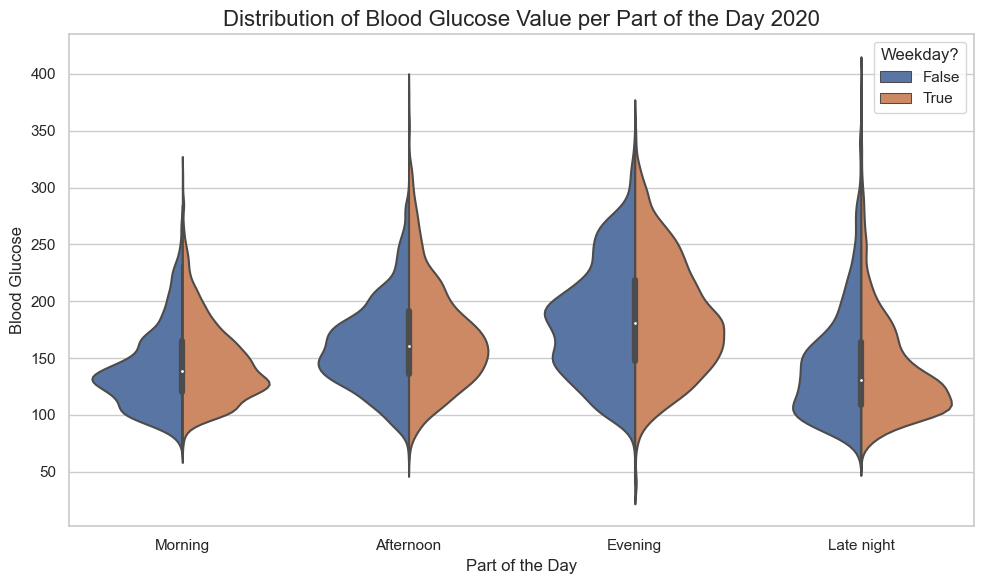

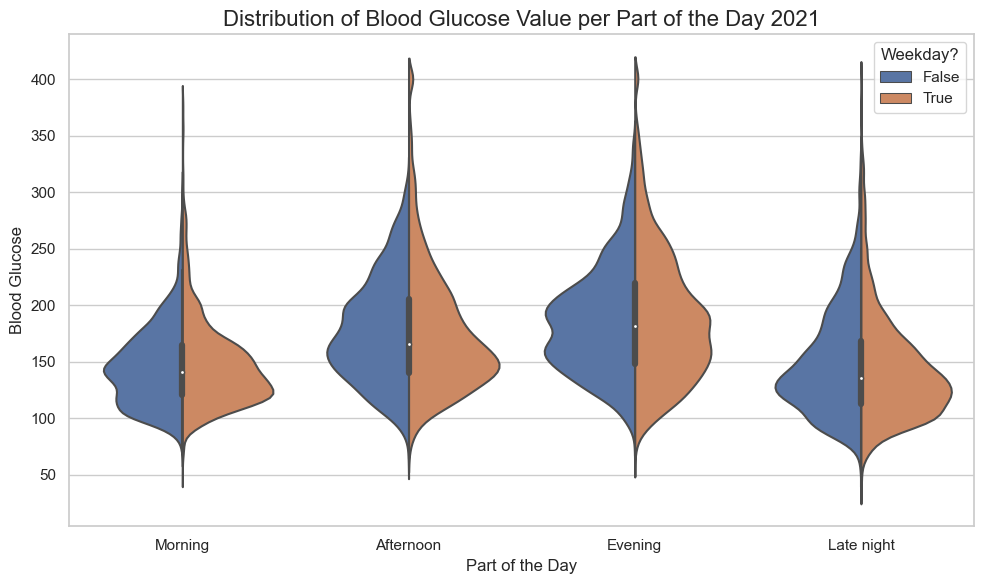

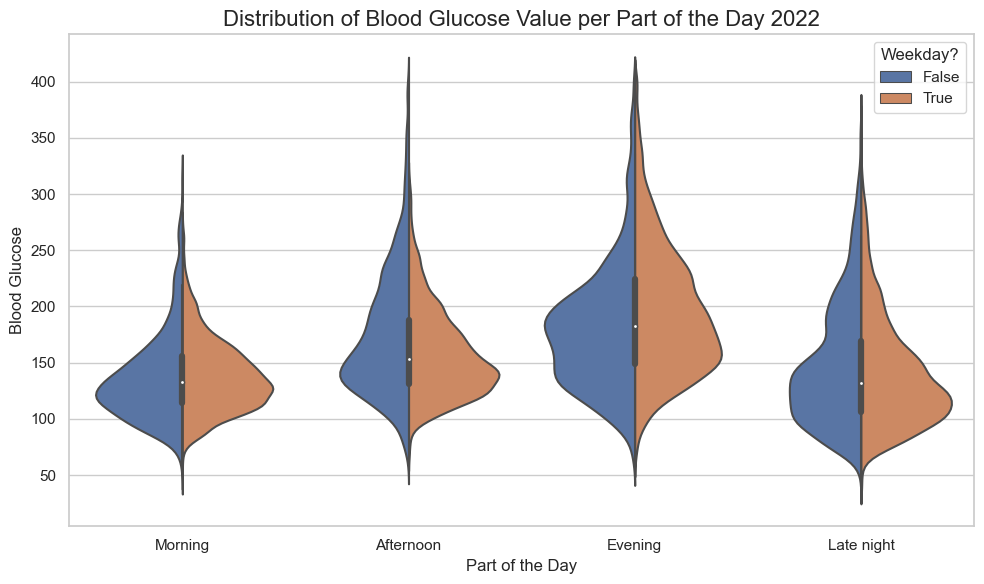

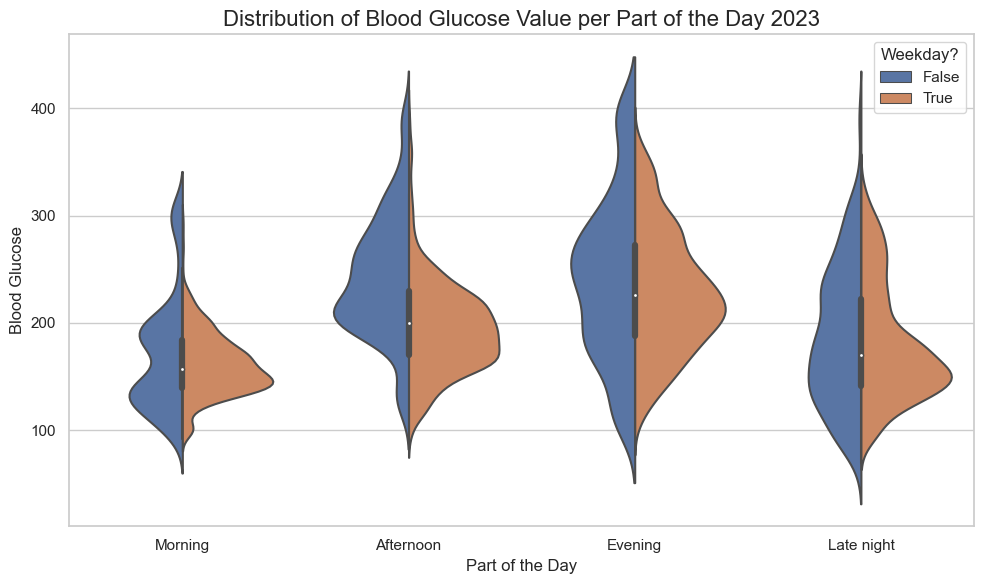

In [36]:
for year in years:
    show_violin(df2, year)

In [37]:
def show_violin_no_legend(df, year):
    ax = sns.violinplot(x="part_of_day",
                        y="value",
                        hue="weekday",
                        split=True,
                        data=df[df['year'] == year],
                        order=['Morning', 'Afternoon', 'Evening', 'Late night'])
    ax.set_title('Distribution of Blood Glucose Value per Part of the Day Over the Years', fontsize=16)

    # Set label for x-axis
    plt.ylabel( "Blood Glucose" , size = 12 )
    plt.xlabel( "Part of the Day" , size = 12 )
    ax.get_legend().remove()

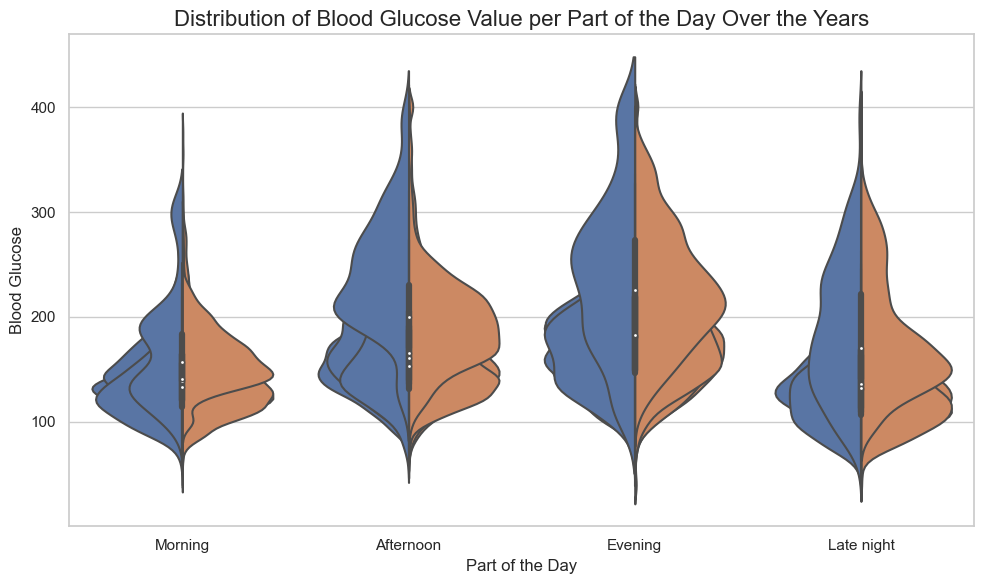

In [38]:
for year in years:
    show_violin_no_legend(df2, year)

## MODELING WITH CLASSIFICATION AND TIME-SERIES FORECASTING

In [39]:
df3 = df2.drop(columns=['value'])

In [40]:
df3.head()

,year,month,day,hour,day_of_year,week_of_year,day_of_week,weekday,part_of_day,high
0,2022,9,15,19,258,37,3,True,Evening,1
1,2022,9,15,17,258,37,3,True,Afternoon,1
2,2022,9,15,18,258,37,3,True,Evening,1
3,2022,9,15,18,258,37,3,True,Evening,1
4,2022,9,15,18,258,37,3,True,Evening,1


### DUMMY VARIABLES

In [41]:
categorical_vars = ['month', 'weekday', 'part_of_day']

In [42]:
for var in categorical_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df3[var], prefix=var)
    dfx=df3.join(cat_list)
    df3=dfx

In [43]:
data_vars=df3.columns.values.tolist()
to_keep=[i for i in data_vars if i not in categorical_vars]

In [44]:
df4=df3[to_keep]
df4.columns.values

array(['year', 'day', 'hour', 'day_of_year', 'week_of_year',
       'day_of_week', 'high', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'weekday_False', 'weekday_True',
       'part_of_day_Afternoon', 'part_of_day_Evening',
       'part_of_day_Late night', 'part_of_day_Morning'], dtype=object)

In [45]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175153 entries, 0 to 175152
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   year                    175153 non-null  int64
 1   day                     175153 non-null  int64
 2   hour                    175153 non-null  int64
 3   day_of_year             175153 non-null  int64
 4   week_of_year            175153 non-null  int64
 5   day_of_week             175153 non-null  int64
 6   high                    175153 non-null  int32
 7   month_1                 175153 non-null  uint8
 8   month_2                 175153 non-null  uint8
 9   month_3                 175153 non-null  uint8
 10  month_4                 175153 non-null  uint8
 11  month_5                 175153 non-null  uint8
 12  month_6                 175153 non-null  uint8
 13  month_7                 175153 non-null  uint8
 14  month_8                 175153 non-null  uint8
 15  

In [46]:
show_values(df4, ['high'])

high
0    124296
1     50857
Name: high, dtype: int64




### SMOTE

In [47]:
X = df4.loc[:, df4.columns != 'high']
y = df4.loc[:, df4.columns == 'high']

os = SMOTE(random_state=493)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=493)

columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['high'])

# we can check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['high']==0]))
print("Number of subscription",len(os_data_y[os_data_y['high']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['high']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['high']==1])/len(os_data_X))

length of oversampled data is  173852
Number of no subscription in oversampled data 86926
Number of subscription 86926
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


### FEATURE SELECTION

In [48]:
cols=['hour',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'weekday_False',
 'weekday_True',
 'part_of_day_Afternoon',
 'part_of_day_Evening',
 'part_of_day_Late night',
 'part_of_day_Morning']

X=os_data_X[cols]
y=os_data_y['high']

### LOGISTIC REGRESSION

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=493)

logreg = LogisticRegression(solver="liblinear")
logreg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [50]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.70


In [51]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[18856  7029]
 [ 8840 17431]]


In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.73      0.70     25885
           1       0.71      0.66      0.69     26271

    accuracy                           0.70     52156
   macro avg       0.70      0.70      0.70     52156
weighted avg       0.70      0.70      0.70     52156



<Figure size 1000x600 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

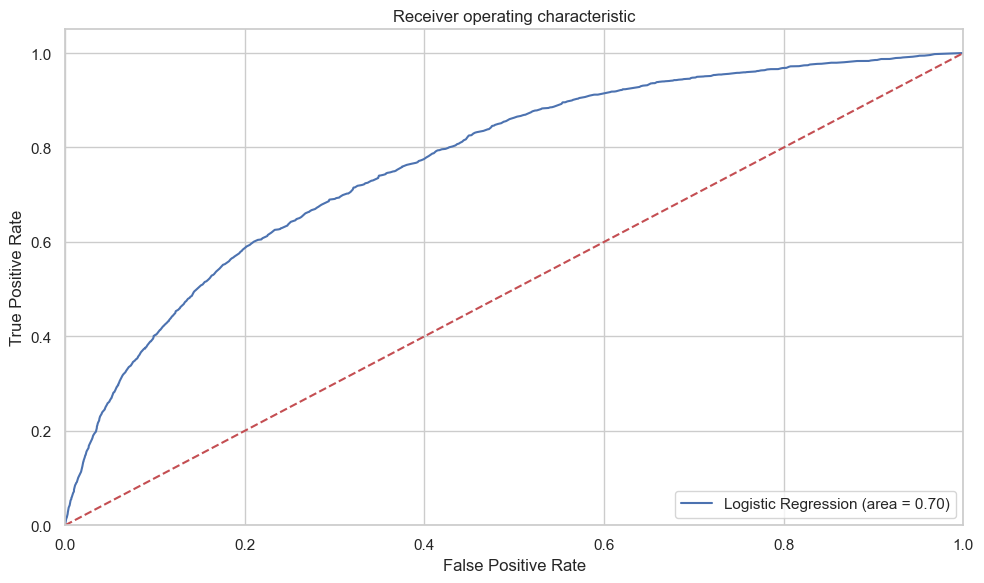

In [53]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### PROPHET

In [54]:
df5 = pd.read_csv('blood_glucose.csv', parse_dates=True, infer_datetime_format=True)

In [55]:
df5.head()

,startDate,value
0,2022-09-15 19:15:48-06:00,341
1,2022-09-15 17:55:48-06:00,278
2,2022-09-15 18:00:47-06:00,277
3,2022-09-15 18:05:47-06:00,266
4,2022-09-15 18:10:48-06:00,264


In [56]:
df5 = df5.rename(columns={'startDate':'ds', 'value':'y'})

In [57]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175153 entries, 0 to 175152
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   ds      175153 non-null  object
 1   y       175153 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.7+ MB


In [58]:
df5["ds"] = pd.to_datetime(df5["ds"])

In [59]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175153 entries, 0 to 175152
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype                                 
---  ------  --------------   -----                                 
 0   ds      175153 non-null  datetime64[ns, pytz.FixedOffset(-360)]
 1   y       175153 non-null  int64                                 
dtypes: datetime64[ns, pytz.FixedOffset(-360)](1), int64(1)
memory usage: 2.7 MB


In [60]:
df5['ds'] = df5['ds'].dt.tz_localize(None)

In [61]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175153 entries, 0 to 175152
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ds      175153 non-null  datetime64[ns]
 1   y       175153 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.7 MB


In [62]:
df6=df5.set_index('ds').resample('D').agg(y=('y', 'mean'))

In [63]:
df6 = df6.reset_index()

In [64]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978 entries, 0 to 977
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      978 non-null    datetime64[ns]
 1   y       662 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.4 KB


04:36:35 - cmdstanpy - INFO - Chain [1] start processing
04:36:35 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1800x600 with 0 Axes>

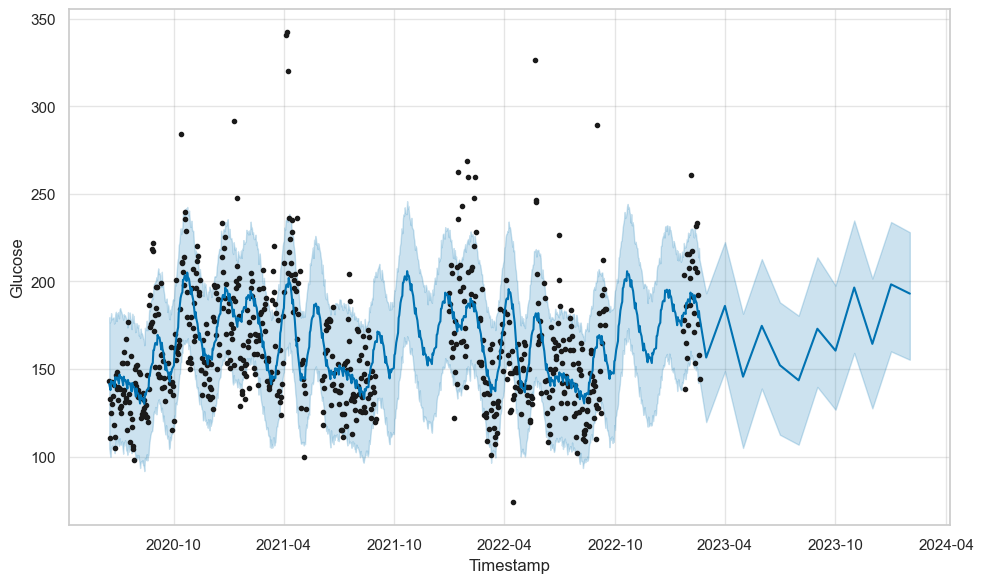

Text(0.5, 1.0, 'Blood Glucose')

<Figure size 1800x600 with 0 Axes>

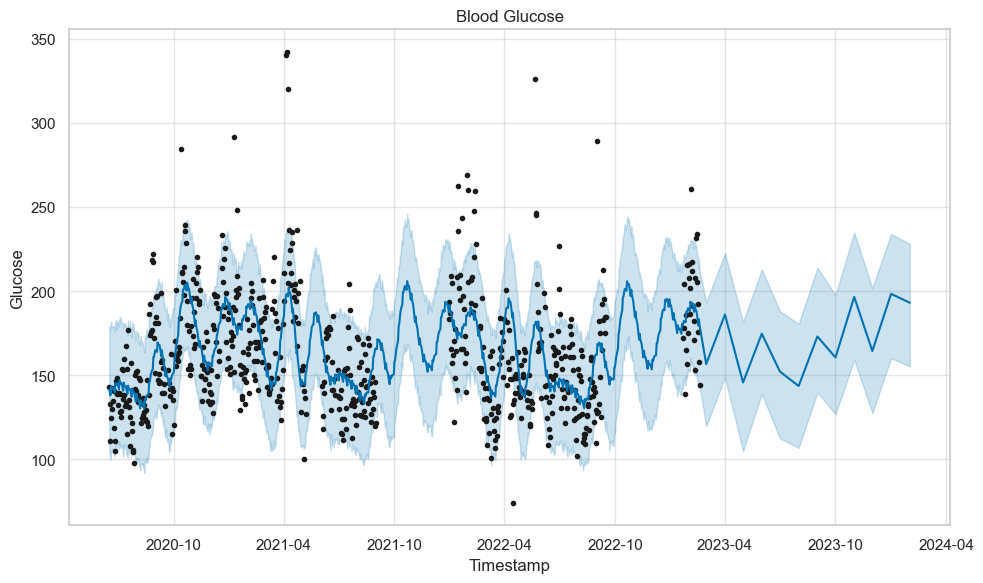

In [66]:
model = Prophet()
model.fit(df6)
df6_forecast = model.make_future_dataframe(periods=12, freq='MS')
df6_forecast = model.predict(df6_forecast)
plt.figure(figsize=(18, 6))
model.plot(df6_forecast, xlabel = 'Timestamp', ylabel = 'Glucose')
plt.title('Blood Glucose')

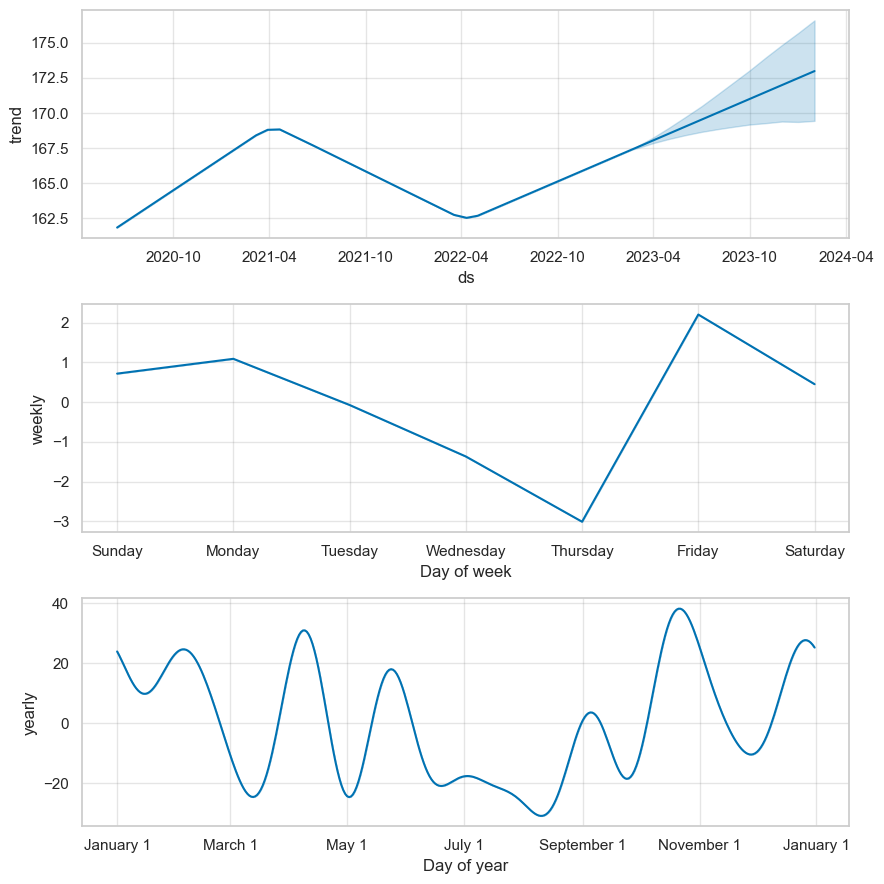

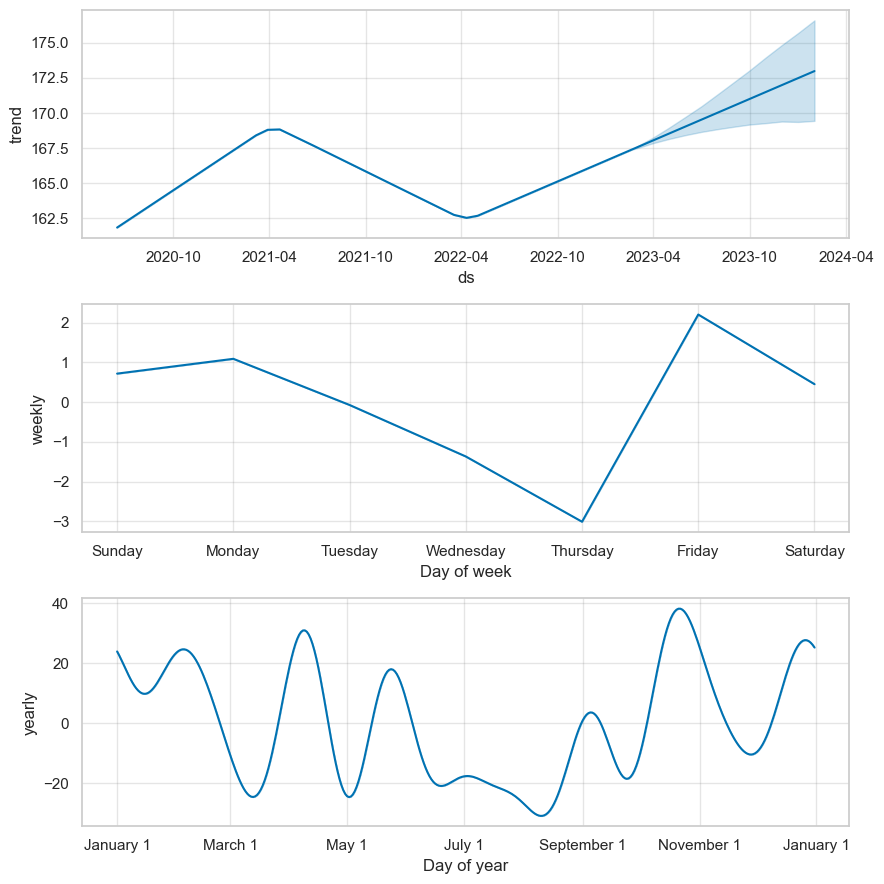

In [67]:
model.plot_components(df6_forecast)